# Implementing Filtered Back Projection

This tutorial is intended to be an example of implementing a custom `CorrectionNet` and corresponding reconstruction algorithm. It will also explore the detail of `ObjectMeta` and `ImageMeta`. We'll use the classes of PyTomography to implemented filtered back projection in SPECT.

In [1]:
import sys
sys.path.append('/home/gpuvmadm/PyTomography/src')
import os
from pytomography.projections import ForwardProjectionNet, BackProjectionNet
from pytomography.metadata import ObjectMeta, ImageMeta
from pytomography.corrections import CorrectionNet
import numpy as np
import matplotlib.pyplot as plt
import torch

The two foundational tools of image reconstruction are

1. Forward projection $\sum_{i} c_{ij} a_i$
2. Back projection $\sum_{j} c_{ij} b_j$

Let's discuss what these operators actually mean. First, let's define our quantities. $c_{ij}$ is known as the system matrix, and may include information involving attenuation and PSF correction. $a_i$ is an arbtriary object and $b_j$ is an arbitrary image. 

It's worth now discussing what the indices $i$ and $j$ actually mean. You might think: objects are three dimensional, shouldn't there be at least 3 indices when we're doing linear operations? Consider the following: because we are in a discrete space, any 3 dimensional object can be converted to a single (albeit very long) one dimensional object: a 128x128x128 3D matrix can be converted into a single 1D vector of length 2097152. That's how many voxels there are in object space: you can think of index $i$ as indexing a single voxel.

The same can be said for an image. If we have 64 projections of matrix size 128x128, then that can be thought of as a single vector of length 1048576. That's also how many individual detector elements there are.

So in forward projection $\sum_{i} c_{ij} a_i$, the system matrix $c_{ij}$ maps the contribution from voxel $i$ to a detector element $j$. In back projection $\sum_{j} c_{ij} b_j$, the system matrix $c_{ij}$ maps the intensity in detector element back to every possible voxel $i$ that could have contributed to it. In reality, however, not every voxel that could have contributed to detector element $j$ does so with equal intensity; it is for this reason that forward projection followed by back projection does not yield the original image. 


Let's experiment with these operators. First we'll make a 3D rectangle in object space:

In [2]:
x = torch.linspace(-1,1,128)
y = torch.linspace(-1,1,128)
z = torch.linspace(-1,1,132)
xv, yv, zv = torch.meshgrid([x,y,z], indexing='ij')
object_truth = (xv>-0.2)*(xv<0.2)*(yv>-0.15)*(yv<0.15)*(zv>-0.1)*(zv<0.1)
object_truth = object_truth.to(torch.float).unsqueeze(dim=0) # add batch dimension
object_truth.shape

torch.Size([1, 128, 128, 132])

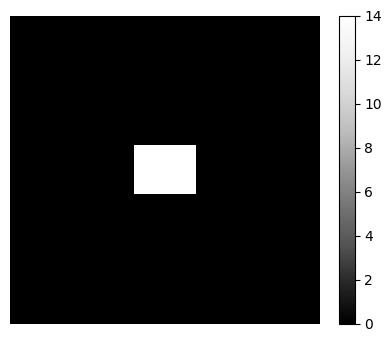

In [3]:
plt.figure(figsize=(5,4))
plt.pcolormesh(object_truth[0].sum(axis=2).T, cmap='Greys_r')
plt.axis('off')
plt.colorbar()

Before we do any projections, we need to get corresponding metadata for our object. In this case, we'll assume the voxel sizes are 1cm $^3$. For our image space, we'll assume 60 projections are taken at angular spacing of 6 degrees.

In [4]:
angles = np.arange(0,360.,6.)
object_meta = ObjectMeta(dr=(1,1,1), shape=object_truth[0].shape)
image_meta = ImageMeta(object_meta, angles=angles)

With this metadata, we can create our forward and back projection networks. We'll use no image correction techniques now.

In [5]:
fp_net = ForwardProjectionNet(object_correction_nets=[],
                              image_correction_nets=[],
                              object_meta=object_meta,
                              image_meta=image_meta)
bp_net = BackProjectionNet(object_correction_nets=[],
                           image_correction_nets=[],
                           object_meta=object_meta,
                           image_meta=image_meta)

We can now use the `fp_net` to convert the object into an image (this is a Mickey-Mouse version of a detector simulation)

In [6]:
image = fp_net(object_truth)
image.shape

torch.Size([1, 60, 128, 132])

We can look at a projection at 60 degrees for example:

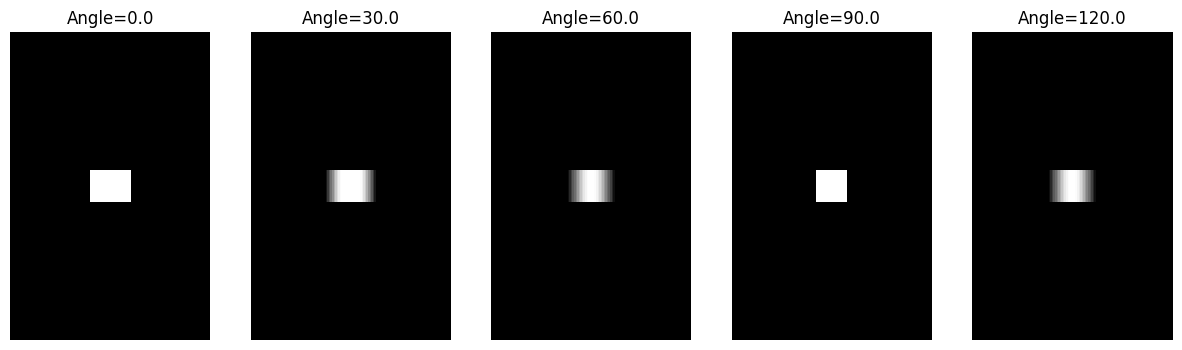

In [7]:
fig, axes = plt.subplots(1,5,figsize=(15,4))
for i, proj in enumerate([0,5,10,15,20]):
    axes[i].pcolormesh(image[0][proj].T, cmap='Greys_r')
    axes[i].set_title(f'Angle={image_meta.angles[proj]}')
    axes[i].axis('off')

At angles like 60 degrees, the cube is darkest in the center and lighter on the outside; this is like looking through a semi-transparent cube in real life, it's going to be darkest near the center if you're looking at it from an off angle.

We can also back project the cube to turn it back into an object

In [8]:
object_new = bp_net(image)
object_new.shape

torch.Size([1, 128, 128, 132])

But if we look at the new object:

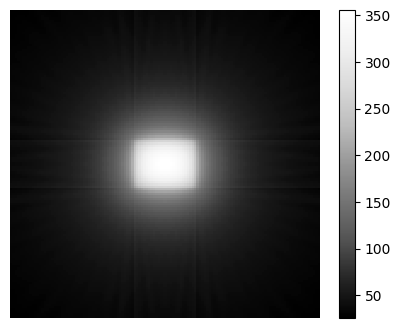

In [9]:
plt.figure(figsize=(5,4))
plt.pcolormesh(object_new[0].sum(axis=2).T, cmap='Greys_r')
plt.axis('off')
plt.colorbar()

We can see that it has been blurred (note: no blurring in the $z$ direction because the voxels at height $z_0$ will only contribute to detector elements at height $z_0$ due to collimation)

**Example**: Filtered Back Projection. In this case the image estimate is given by

$$\hat{f}_i = \pi \sum_j c_{ij} \left( \mathcal{F}^{-1}(|\omega|\mathcal{F}(g)) \right)_j $$

where the term in brackets involves applying a 1D convolution (in this case, multiplication in Fourier space with the Ramp filter) to the image along the $r$ axis.

In [10]:
freq_fft = torch.fft.fftfreq(image.shape[-2]) 
filter = torch.abs(freq_fft).reshape((-1,1))
image_fft = torch.fft.fft(image, axis=-2)
image_fft = image_fft* filter
image_filtered = torch.fft.ifft(image_fft, axis=-2).real

In [11]:
object_fbp = bp_net(image_filtered) *np.pi

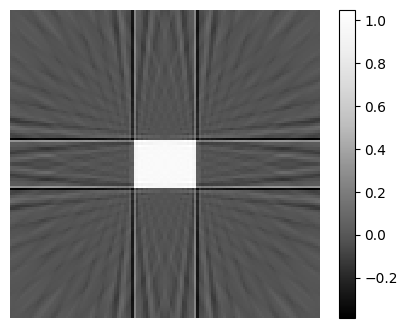

In [12]:
plt.figure(figsize=(5,4))
plt.pcolormesh(object_fbp[0][:,:,64].T, cmap='Greys_r')
plt.axis('off')
plt.colorbar()

The cube is no longer blurred, but artifacts are present. Such artifacts are not present when using algorithms like OSEM for reconstruction.

Since this operation is applied to the image before back projection, we can include turn it into a subclass of the `CorrectionNet`.
* It has to have `CorrectionNet` as a parent class
* It has to implement the `forward` function. In this case, since it's a correction done in image space, it has to take in an image and return an image

In [13]:
class RampCorrectionNet(CorrectionNet):
    def __init__(self, device='cpu'):
        super(RampCorrectionNet, self).__init__(device)
    @torch.no_grad()
    def forward(self, image):
        freq_fft = torch.fft.fftfreq(image.shape[-2]) 
        filter = torch.abs(freq_fft).reshape((-1,1))
        image_fft = torch.fft.fft(image, axis=-2)
        image_fft = image_fft* filter
        image_filtered = np.pi * torch.fft.ifft(image_fft, axis=-2).real
        return image_filtered

Now we can create a new back projection network that implements this ramp filter:

In [14]:
ramp_correction_net = RampCorrectionNet()
bp_rampfilter_net = BackProjectionNet(object_correction_nets=[],
                                    image_correction_nets=[ramp_correction_net],
                                    object_meta=object_meta,
                                    image_meta=image_meta)

And we can get our object using the back projection net which uses filtering

In [15]:
object_fbp = bp_rampfilter_net(image)

And sure enough it's the same:

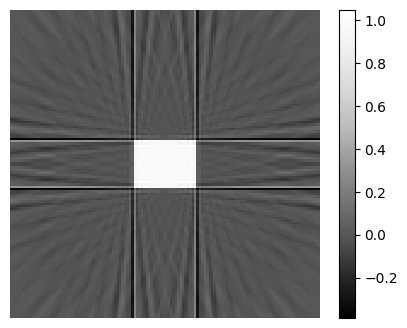

In [16]:
plt.figure(figsize=(5,4))
plt.pcolormesh(object_fbp[0][:,:,64].T, cmap='Greys_r')
plt.axis('off')
plt.colorbar()